In [1]:
import logging

import numpy as np
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline
logging.getLogger().setLevel(logging.INFO)


# Other option payoffs:

* Bull Spread: Difference of two calls: $ V(S,T) = \max(S-K_1,0) - \max(S-K_2,0) $ 
* Bear Spread: Difference of two puts: $ V(S,T) = \max(K_1-S,0) - \max(K_2-S,0) $
* Straddle: `\/` Put and call with the same strike price: $ V(S,T) = \max(S-K,0) + \max(S-K,0)$
* Strangle: `\_/` Put and call with different stike prices: $ V(S,T) = \max(S-K_1,0) + \max(S-K_2,0) $
* Butterfly: `_/\_` Involves 3 strike prices
* Condor: `_/-\_` Involves 4 strike prices

In [2]:
from tests.black_scholes.option_models import EuropeanCallFormula, EuropeanPutFormula

def getEuropeanSolutions(Smin:float,Smax:float,num_qbits:float,
                         r:float,sigma:float,tau:float, 
                        combination_data:list[tuple[str,float,float]])->np.ndarray[float]:
    x = np.linspace(Smin,Smax,2**num_qbits)
    sol = np.zeros(2**num_qbits,np.float64)
    for (type,strike,scale) in combination_data:
        if type.capitalize() == 'C':
            for i,S in enumerate(x):
                sol[i] += scale*EuropeanCallFormula(S, tau, strike, r, sigma)
        else:
            for i,S in enumerate(x):
                sol[i] += scale*EuropeanPutFormula(S, tau, strike, r, sigma)
    return sol



In [3]:
from tests.black_scholes.option_models import EuropeanCallState, EuropeanPutState

def BullSpreadPayoff(Smin:float,Smax:float,
                     K1:float,K2:float,
                     num_qbits:int) -> np.ndarray[float]:
    # assert K2 > K1
    Kmin = min(K1,K2)
    Kmax = max(K1,K2)
    return EuropeanCallState(Smin,Smax,Kmin,num_qbits) - EuropeanCallState(Smin,Smax,Kmax,num_qbits)

def BearSpreadPayoff(Smin:float,Smax:float,
                     K1:float,K2:float,
                     num_qbits:int) -> np.ndarray[float]:
    # assert K2 > K1
    Kmin = min(K1,K2)
    Kmax = max(K1,K2)
    return EuropeanPutState(Smin,Smax,Kmax,num_qbits) - EuropeanPutState(Smin,Smax,Kmin,num_qbits)

def StraddlePayoff(Smin:float,Smax:float,
                   K:float,num_qbits:int) ->np.ndarray[float]:
    return EuropeanCallState(Smin,Smax,K,num_qbits) + EuropeanPutState(Smin,Smax,K,num_qbits)

def StranglePayoff(Smin:float,Smax:float,
                   K1:float,K2:float,
                   num_qbits:int) -> np.ndarray[float]:
    Kmin = min(K1,K2)
    Kmax = max(K1,K2)

    return EuropeanPutState(Smin,Smax,Kmin,num_qbits) + EuropeanCallState(Smin,Smax,Kmax,num_qbits)

def ButterflyPayoff(Smin:float,Smax:float,
                    K:float,a:float,
                    num_qbits:int) -> np.ndarray[float]:
    return np.sum(
        [
        EuropeanCallState(Smin,Smax,K-a,num_qbits),
        -2*EuropeanCallState(Smin,Smax,K,num_qbits),
        EuropeanCallState(Smin,Smax,K+a,num_qbits),
        ], axis=0)

def CondorPayoff(Smin:float,Smax:float,
                 K1:float,K2:float,a:float,
                 num_qbits:int) -> np.ndarray[float]:
    Kmin = min(K1,K2)
    Kmax = max(K1,K2)
    return np.sum(
        [
            EuropeanCallState(Smin,Smax,Kmin,num_qbits),
            -EuropeanCallState(Smin,Smax,Kmin+a,num_qbits),
            -EuropeanCallState(Smin,Smax,Kmax,num_qbits),
            EuropeanCallState(Smin,Smax,Kmax+a,num_qbits),
        ],axis=0)



n = 4
Smin=0
Smax=150
x = np.linspace(Smin,Smax,2**n)

from functools import partial

bear = partial(BearSpreadPayoff, Smin=Smin,Smax=Smax,num_qbits=n)
bull = partial(BullSpreadPayoff, Smin=Smin,Smax=Smax,num_qbits=n)
straddle = partial(StraddlePayoff, Smin=Smin,Smax=Smax,num_qbits=n)
strangle = partial(StranglePayoff, Smin=Smin,Smax=Smax,num_qbits=n)
butterlfy = partial(ButterflyPayoff, Smin=Smin,Smax=Smax,num_qbits=n)
condor = partial(CondorPayoff, Smin=Smin,Smax=Smax,num_qbits=n)
K1 = 50
K2 = 100
K = 75
a = 20
def getSols(r,sigma,T):
    sols = np.zeros((6,2**n),np.float64)
    sols[0,:] = getEuropeanSolutions(Smin,Smax,n, r,sigma, T, 
                                combination_data=[('p',K1,-1),
                                                    ('p',K2,1)])
    sols[1,:] = getEuropeanSolutions(Smin,Smax,n, r,sigma, T, 
                                combination_data=[('c',K1,1),
                                                    ('c',K2,-1)])
    sols[2,:] = getEuropeanSolutions(Smin,Smax,n, r,sigma, T, 
                                combination_data=[('c',K,1),
                                                    ('p',K,1)])
    sols[3,:] = getEuropeanSolutions(Smin,Smax,n, r,sigma, T, 
                                combination_data=[('p',K1,1),
                                                    ('c',K2,1)])
    sols[4,:] = getEuropeanSolutions(Smin,Smax,n, r,sigma, T, 
                                combination_data=[('c',K-a,1),
                                                    ('c',K,-2),
                                                    ('c',K+a,1)])
    sols[5,:] = getEuropeanSolutions(Smin,Smax,n, r,sigma, T, 
                                combination_data=[('c',K1,1),
                                                    ('c',K1+a,-1),
                                                    ('c',K2,-1),
                                                    ('c',K2+a,1)])
    return sols

T=1.0
dt=0.1
Nt = int(np.ceil(T/dt))

analytical_sols = np.zeros((Nt,6,2**n))
for ti in range(1,Nt+1):
    analytical_sols[ti-1,:,:] = getSols(r:=0.04,sigma:=0.2, tau:=dt*ti)

c:\Users\CMP3KUMARS\qnute\tests\black_scholes\option_models.py:17: RuntimeWarning: divide by zero encountered in log
  d_plus = (np.log(S/strike) + (r+sigma**2/2)*tau) / (sigma*np.sqrt(tau))


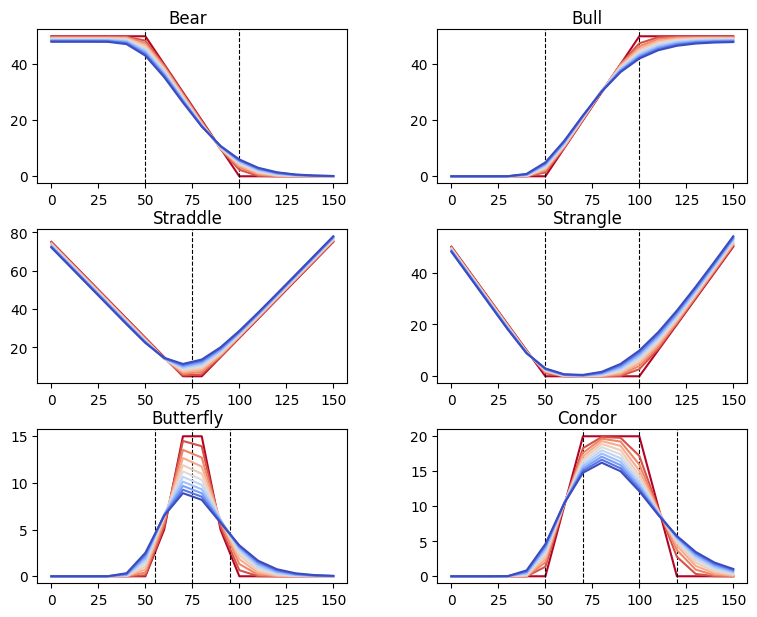

In [4]:

cmap = plt.get_cmap('coolwarm')

fig = plt.figure(figsize=(8,6))
# fig,axs = plt.subplots(6,1, figsize=(8,12), sharex='all', sharey='row')
subfigs = fig.subfigures(3,2)
axs = [ None ] * 6
titles = ['Bear', 'Bull', 'Straddle', 'Strangle', 'Butterfly', 'Condor']
for i in range(6):
    axs[i] = subfigs.flatten()[i].subplots(1,sharex=True,sharey=True)
    subfigs.flatten()[i].suptitle(titles[i])

axs[0].plot(x, bear(K1=K1,K2=K2),label='$\\tau=0.0$',color=cmap(1.0))
axs[1].plot(x, bull(K1=K1,K2=K2),label='$\\tau=0.0$',color=cmap(1.0))
axs[2].plot(x, straddle(K=K),label='$\\tau=0.0$',color=cmap(1.0))
axs[3].plot(x, strangle(K1=K1,K2=K2),label='$\\tau=0.0$',color=cmap(1.0))
axs[4].plot(x, butterlfy(K=K, a=a),label='$\\tau=0.0$',color=cmap(1.0))
axs[5].plot(x, condor(K1=K1, K2=K2, a=a),label='$\\tau=0.0$',color=cmap(1.0))

for i in [0,1,3,5]:
    axs[i].axvline(x=K1,linewidth=0.8,linestyle='--',color='k')
    axs[i].axvline(x=K2,linewidth=0.8,linestyle='--',color='k')
for i in [2,4]:
    axs[i].axvline(x=K,linewidth=0.8,linestyle='--',color='k')
axs[4].axvline(x=K-a,linewidth=0.8,linestyle='--',color='k')
axs[4].axvline(x=K+a,linewidth=0.8,linestyle='--',color='k')
axs[5].axvline(x=K1+a,linewidth=0.8,linestyle='--',color='k')
axs[5].axvline(x=K2+a,linewidth=0.8,linestyle='--',color='k')

for i in range(6):
    for ti in range(1,Nt+1):
        tau = ti*dt
        axs[i].plot(x,analytical_sols[ti-1,i,:], label=f'$\\tau={tau:0.2f}$',color=cmap(1.0 - tau/T))

plt.show()

In [5]:
from tests.black_scholes import BlackScholesInfo, BoundaryConditions, Basis, bs_logger
from tests.black_scholes.hamiltonian import generateBlackScholesHamiltonian

bs_data = BlackScholesInfo(r,q:=0.0,sigma,Basis.S,
                           Smin,Smax,
                           BC:=BoundaryConditions.DOUBLE_LINEAR)

H = generateBlackScholesHamiltonian(bs_data, n)


In [37]:
from tests.black_scholes.simulation import run_blackScholes_simulation, rescale_qnute_bs_sols

# VT = strangle(K1=K1,K2=K2)
# VT = butterlfy(K=K,a=a)
VT = condor(K1=K1,K2=K2,a=a)
rescale_hamiltonian = True
qnute_sols,qnute_norms = run_blackScholes_simulation(VT, bs_data, n, np.arange(2,n+2,2), T, Nt, normalize_hamiltonian=rescale_hamiltonian)
# rescaled_sols, C_psi = rescale_qnute_bs_sols(VT, bs_data, qnute_sols, qnute_norms, T, rescale_frequency=(rescale_freq:=1))

INFO:QNUTE Logger:Performing initial measurements...
INFO:QNUTE Logger:Starting QNUTE Iterations:
INFO:QNUTE Logger:    Iteration 001
INFO:QNUTE Logger:      Finished in 0.00 seconds.
INFO:QNUTE Logger:    Iteration 010
INFO:QNUTE Logger:      Finished in 0.02 seconds.
INFO:QNUTE Logger:Performing initial measurements...
INFO:QNUTE Logger:Starting QNUTE Iterations:
INFO:QNUTE Logger:    Iteration 001
INFO:QNUTE Logger:      Finished in 0.03 seconds.
INFO:QNUTE Logger:    Iteration 010
INFO:QNUTE Logger:      Finished in 0.05 seconds.


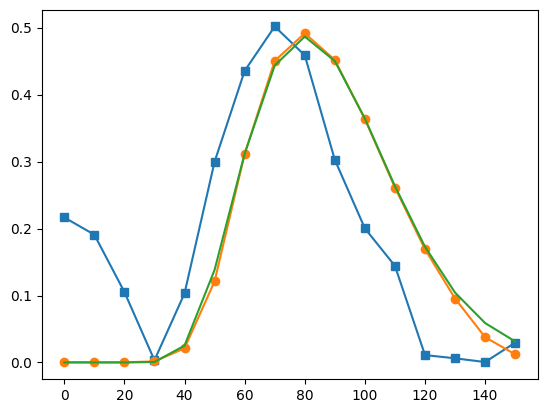

In [38]:
markers = 'so'
for Di,D in enumerate([2,4]):
    plt.plot(x, qnute_sols[Di,-1,:], marker=markers[Di])
    # plt.axhline(y=np.sqrt(rescaled_sols[1,-1,0]*rescaled_sols[1,-1,-1]))
plt.plot(x,(sol:=analytical_sols[-1,-1,:])/np.linalg.norm(sol))
plt.show()

50.89537367687996

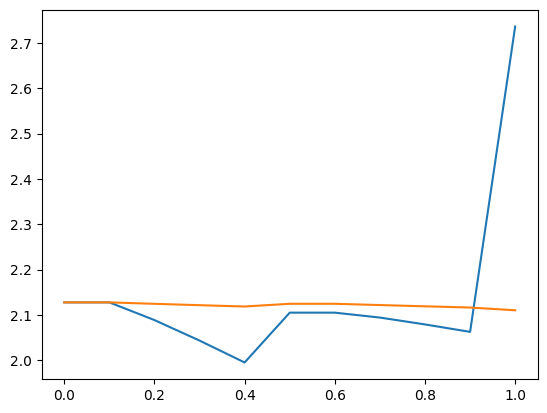

In [24]:
for Di,D in enumerate([2,4]):
    plt.plot(np.arange(Nt+1)*dt, np.log10(C_psi[Di,:]))
plt.show()

In [ ]:
# from tests.black_scholes.run_test import run_blackScholes_simulation
from tests.black_scholes import BlackScholesInfo, BoundaryConditions, Basis, bs_logger
from tests.black_scholes.hamiltonian import generateBlackScholesHamiltonian
from tests.black_scholes.option_models import EuropeanCallFormula, EuropeanPutFormula, EuropeanCallState, EuropeanPutState
from qnute.simulation.numerical_sim import qnute
from qnute.simulation.parameters import QNUTE_params as Params
def run_blackScholes_simulation(maturity_state:np.ndarray[float],
                                bs_data:BlackScholesInfo,
                                num_qbits:int,
                                D_list:np.ndarray[int],
                                T:float,
                                Nt:int,*,rescale_ham:bool=False
                                ) -> tuple[np.ndarray[float],np.ndarray[float]]:
    N = 2**num_qbits
    assert maturity_state.shape[0] == N
    dt = T/Nt
    c0 = np.linalg.norm(maturity_state)
    psi0 = maturity_state/c0

    qnute_sols = np.zeros((D_list.shape[0],Nt+1,N), np.float64)
    qnute_norms = np.zeros((D_list.shape[0],Nt+1), np.float64)

    BSHam = generateBlackScholesHamiltonian(bs_data, num_qbits)
    if rescale_ham:
        ham_scale = np.max(np.abs(BSHam.pterm_list['amplitude']))
        print(ham_scale)
        dt *= ham_scale
        BSHam *= 1.0/ham_scale

    params = Params(BSHam*(-1), 1, num_qbits)
    params.set_run_params(dt,0.1,Nt,0,None,init_sv=psi0,trotter_flag=True)

    for Di,D in enumerate(D_list):
        u_domains = [list(range(i,i+D)) for i in range(num_qbits-D+1)]
        params.load_hamiltonian_params(D, u_domains, True, True)
        out = qnute(params, log_frequency=500, c0=c0)
        qnute_sols[Di,:,:] = np.abs(out.svs.real)
        qnute_norms[Di,:] = np.array(out.c_list)
    return (qnute_sols,qnute_norms)

bs_data = BlackScholesInfo(r:=0.04,q:=0,sigma:=0.2,
                           basis:=Basis.S,Smin:=0,Smax:=150,
                           BC:=BoundaryConditions.DOUBLE_LINEAR)

strike = 50
n = 5
N=2**n
T = 3
Nt = 100
dt = T/Nt

PUT = True

if PUT:
    VT = EuropeanPutState(Smin,Smax,strike,n)
    analytical_sol = np.array([[EuropeanPutFormula(S,tau,strike,r,sigma) for S in np.linspace(Smin,Smax,N)] for tau in np.linspace(0.0,T,Nt+1)])
else:
    VT = EuropeanCallState(Smin,Smax,strike,n)
    analytical_sol = np.array([[EuropeanCallFormula(S,tau,strike,r,sigma) for S in np.linspace(Smin,Smax,N)] for tau in np.linspace(0.0,T,Nt+1)])

qnute_sols, qnute_norms = run_blackScholes_simulation(VT, bs_data, n, np.array([4]), T, Nt, rescale_ham=True)

In [ ]:
plt.plot(np.arange(BSHams[-1].pterm_list.shape[0]),(np.abs(BSHams[-1].pterm_list['amplitude'])))

In [ ]:
# plt.plot(np.arange(N**2),np.log10(np.abs(BSHams[-1].get_matrix().real.flatten())))
# plt.imshow(lH:=np.log10(np.abs(BSHams[-1].get_matrix().real)))
mat = BSHams[-1].get_matrix().real
pmax = np.max(np.abs(BSHams[-1].pterm_list['amplitude']))
plt.imshow(pmat:=(mat/pmax))
plt.colorbar()
plt.show()
plt.imshow(np.log10(np.abs(pmat)))
plt.colorbar()
plt.show()

In [ ]:
pmax

In [ ]:
BCs = [BoundaryConditions.DOUBLE_DIRICHLET_NODE, BoundaryConditions.DOUBLE_LINEAR]

In [ ]:
def EuropeanPutState(Smin:float, Smax:float, strike:float, num_qbits:int) -> np.ndarray[float]:
    N = 2**num_qbits
    V = np.where((S:=np.linspace(Smin,Smax,N)) < strike, strike - S, 0.0)
    return V

def EuropeanCallState(Smin:float, Smax:float, strike:float, num_qbits:int) -> np.ndarray[float]:
    N = 2**num_qbits
    V = np.where((S:=np.linspace(Smin,Smax,N)) > strike, S-strike, 0.0)
    return V

Vput = EuropeanPutState(Smin,Smax, K:=50, n)
Vcal = EuropeanCallState(Smin,Smax,K,n)
N=2**n
plt.plot(x:=np.linspace(Smin,Smax,N), Vput, marker='*',label='Put')
plt.plot(x, Vcal, marker='o',label='Call')
plt.axvline(x=K,linestyle='dashed', label='Strike Price',color='g',linewidth=1.0)
plt.legend()
plt.xticks(np.arange(Smin,Smax+10,10),minor=True)
plt.grid(True,which='both')
plt.show()

# QNUTE Simulations

In [ ]:
from qnute.simulation.numerical_sim import qnute, qnute_logger
from qnute.simulation.parameters import QNUTE_params as Params
qnute_logger.setLevel(logging.INFO)

T = 3
Nt = 1000
dt = T/Nt

psiPut = Vput / (cPut:=np.linalg.norm(Vput))
psiCal = Vcal / (cCal:=np.linalg.norm(Vcal))

solutionsPut = np.zeros((len(BCs), Nt+1, N),np.float64)
solutionsCal = np.zeros((len(BCs), Nt+1, N),np.float64)

for i,BC in enumerate(BCs):
    H = BSHams[BC.value]
    logging.info('Running Boundary conditions: %s', BC.name)
    
    params = Params(H*(-1), 1, n)
    params.load_hamiltonian_params(4,[[0,1,2,3]],True,True)
    params.set_run_params(dt, 0.1, Nt, 0, None, init_sv=psiCal, trotter_flag=True)
    logging.info('  Running Call Options')
    out = qnute(params, log_frequency=500, c0 = cCal)
    solutionsCal[i,:,:] = out.svs.real
    for ti in range(Nt+1):
        solutionsCal[i,ti,:] *= np.prod(out.c_list[0:ti+1])
    
    params.set_run_params(dt, 0.1, Nt, 0, None, init_sv=psiPut, trotter_flag=True)
    logging.info('  Running Put Options')
    out = qnute(params, log_frequency=500, c0 = cPut)
    solutionsPut[i,:,:] = out.svs.real
    for ti in range(Nt+1):
        solutionsPut[i,ti,:] *= np.prod(out.c_list[0:ti+1])


In [ ]:
from scipy.stats import norm

def C(S,t):
    d_plus = (np.log(S/K) + (r+sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d_minus = d_plus - (sigma*np.sqrt(T-t))
    
    return norm.cdf(d_plus)*S - norm.cdf(d_minus) * K * np.exp(-r*(T-t))

def P(S,t):
    return K*np.exp(-r*(T-t)) - S + C(S,t)

CSolsAnalytical = np.zeros((Nt+1,N))
CSolsAnalytical[Nt,:] = Vcal
for ti in range(Nt):
    for Si,S in enumerate(np.linspace(Smin,Smax,N)):
        CSolsAnalytical[ti,Si] = C(S, ti*dt)

PSolsAnalytical = np.zeros((Nt+1,N))
PSolsAnalytical[Nt,:] = Vput
for ti in range(Nt):
    for Si,S in enumerate(np.linspace(Smin,Smax,N)):
        PSolsAnalytical[ti,Si] = P(S, ti*dt)

In [ ]:
for ti in range(0,Nt+1,100):
    fig,axs = plt.subplots(2,1,sharex=True)
    for i,BC in enumerate(BCs):
        axs[0].plot(x,np.abs((sol:=solutionsPut[i,ti,:]))/np.linalg.norm(sol), label=BCs[i].name)
        axs[1].plot(x,np.abs((sol:=solutionsCal[i,ti,:])/np.linalg.norm(sol)), label=BCs[i].name)
    axs[0].plot(x,(sol:=PSolsAnalytical[Nt-ti,:])/np.linalg.norm(sol),label='Analytical', linestyle='dashed',color='k')
    axs[1].plot(x,(sol:=CSolsAnalytical[Nt-ti,:])/np.linalg.norm(sol),label='Analytical', linestyle='dashed',color='k')
    axs[0].axvline(x=K,linestyle='dashed',color='black',linewidth=0.5,label='Strike Price')
    axs[1].axvline(x=K,linestyle='dashed',color='black',linewidth=0.5)
    axs[0].legend()
    fig.suptitle(f'Normalised Solutions at t={ti*dt}')
    axs[0].set_title('Put Options')
    axs[1].set_title('Call Options')
    plt.show()

In [ ]:
cmap = plt.get_cmap('coolwarm')

fig,axs = plt.subplots(2,1,sharex=True,figsize=(10,6))
axs[0].set_title('Put Options')
axs[1].set_title('Call Options')
for ti,t in list(enumerate(np.linspace(0.0,T,Nt+1)))[::100]:
    l, = axs[0].plot(x, PSolsAnalytical[ti,:], label=f'$\\tau={T-t:0.1f}$', color=cmap(t/T))
    axs[1].plot(x, CSolsAnalytical[ti,:], color=l.get_color())
fig.legend(loc='center right')
plt.show()

In [ ]:
a0 = (CSolsAnalytical[0,-1] - CSolsAnalytical[0,-2]) / dS
b0 = CSolsAnalytical[0,-1] - Smax*a0

print(c:=CSolsAnalytical[::100,-1][::-1])

a = np.zeros(c.shape[0])
b = np.zeros(c.shape[0])

for ti,t in enumerate(list((np.linspace(0.0,T,Nt+1)))[::100]):
    a[ti] = 1.0
    b[ti] = b0*np.exp(r*t)

print((a*Smax + b)[::-1])

In [ ]:
fidelity = np.zeros((2,len(BCs),Nt+1))
lognormratio = np.zeros((2,len(BCs),Nt+1))
for i,BC in enumerate(BCs):
    for ti,t in enumerate(np.linspace(0.0,T,Nt+1)):
        fidelity[0,i,ti] = np.dot( np.abs(solutionsPut[i,ti,:]/np.linalg.norm(solutionsPut[i,ti,:])), PSolsAnalytical[ti,:]/np.linalg.norm(PSolsAnalytical[ti,:]) )
        fidelity[1,i,ti] = np.dot( np.abs(solutionsCal[i,ti,:]/np.linalg.norm(solutionsCal[i,ti,:])), CSolsAnalytical[ti,:]/np.linalg.norm(CSolsAnalytical[ti,:]) )
        lognormratio[0,i,ti] = np.log10( np.linalg.norm(solutionsPut[i,ti,:]) / np.linalg.norm(PSolsAnalytical[i,:]) )
        lognormratio[1,i,ti] = np.log10( np.linalg.norm(solutionsCal[i,ti,:]) / np.linalg.norm(CSolsAnalytical[i,:]) )


fig,axs = plt.subplots(1,2,sharex=True,figsize=(8,4))
for i,BC in enumerate(BCs):
    for j in range(2):
        axs[j].plot(t:=np.linspace(0.0,T,Nt+1),fidelity[j,i,:], label=BC.name)
fig.suptitle('Fidelity')
axs[0].set_title('Put Options')
axs[1].set_title('Call Options')
axs[0].legend()
plt.show()

fig,axs = plt.subplots(1,2,sharex=True,figsize=(8,4))
for i,BC in enumerate(BCs):
    for j in range(2):
        axs[j].plot(t:=np.linspace(0.0,T,Nt+1),lognormratio[j,i,:], label=BC.name)
fig.suptitle('Log Norm Ratio')
axs[0].set_title('Put Options')
axs[1].set_title('Call Options')
axs[0].legend()
plt.show()

# Rescaling The Unit Solutions

In [ ]:
dS

In [ ]:
def get_ab(V0, Smin,Smax,dS, Nt, T):
    a0_right = (V0[-1] - V0[-2])/dS
    b0_right = V0[-1] - Smax*a0_right

    a0_left = (V0[1] - V0[0])/dS
    b0_left = V0[0] - Smin*a0_left

    ar = np.zeros(Nt+1)
    br = np.zeros(Nt+1)
    al = np.zeros(Nt+1)
    bl = np.zeros(Nt+1)

    ar = a0_right * np.exp(-(q/Smax)*(T-np.linspace(T,0,Nt+1)))
    br = b0_right * np.exp(-r*(T-np.linspace(T,0,Nt+1)))

    al = a0_left * np.exp(-(q/Smax)*(T-np.linspace(T,0,Nt+1)))
    bl = b0_left * np.exp(-r*(T-np.linspace(T,0,Nt+1)))

    return ar,br,al,bl


V = Vcal
ar,br,al,bl = get_ab(V, Smin, Smax,dS, Nt, T)

plt.plot(x,V)
plt.show()

# plt.plot(np.linspace(0.0,T,Nt+1), ar, label='$a_r$')
# plt.plot(np.linspace(0.0,T,Nt+1), br, label='$b_r$')
# plt.plot(np.linspace(0.0,T,Nt+1), al, label='$a_l$')
# plt.plot(np.linspace(0.0,T,Nt+1), bl, label='$b_l$')
plt.plot(np.linspace(0.0,T,Nt+1), fl:=(al*Smin + bl), label='$f_0^t$ reconstructed')
plt.plot(np.linspace(0.0,T,Nt+1), CSolsAnalytical[::-1,0], label='$f_0^t$ analytical',linestyle='--')
plt.plot(np.linspace(0.0,T,Nt+1), fr:=(ar*Smax + br), label='$f_N^t$ reconstructed')
plt.plot(np.linspace(0.0,T,Nt+1), CSolsAnalytical[::-1,-1], label='$f_N^t$ analytical',linestyle='--')
plt.xlabel(r'$\tau$')
plt.legend()
plt.show()


In [ ]:
pNormSols = np.abs(solutionsPut.copy())/np.linalg.norm(solutionsPut,axis=2,keepdims=True)
cNormSols = np.abs(solutionsCal.copy())/np.linalg.norm(solutionsCal,axis=2,keepdims=True)

# VPL = PSolsAnalytical[::-1,0]
# VPR = PSolsAnalytical[::-1,-1]
# VCL = CSolsAnalytical[::-1,0]
# VCR = CSolsAnalytical[::-1,-1]

(Par,Pbr,Pal,Pbl) = get_ab(Vput, Smin,Smax,dS, Nt, T)
(Car,Cbr,Cal,Cbl) = get_ab(Vcal, Smin,Smax,dS, Nt, T)

VPR = Smax*Par + Pbr
VPL = Smin*Pal + Pbl
VCR = Smax*Car + Cbr
VCL = Smin*Cal + Cbl

for ti in range(0,Nt+1,100):
    fig,axs = plt.subplots(2,1,sharex=True)
    for i,BC in enumerate(BCs):
        if BC == BoundaryConditions.DOUBLE_DIRICHLET_NODE:
            continue
        axs[0].plot(x,pNormSols[i,ti,:]*(VPR[ti]/pNormSols[i,ti,-1]), label=f'right reconstruction')
        axs[0].plot(x,pNormSols[i,ti,:]*(VPL[ti]/pNormSols[i,ti,0]), label=f'left reconstruction')
        axs[1].plot(x,cNormSols[i,ti,:]*(VCR[ti]/cNormSols[i,ti,-1]), label=f'right reconstruction')
        axs[1].plot(x,cNormSols[i,ti,:]*(VCL[ti]/cNormSols[i,ti,0]), label=f'left reconstruction')
    axs[0].plot(x,(sol:=PSolsAnalytical[Nt-ti,:]),label='Analytical', linestyle='dashed',color='k')
    axs[1].plot(x,(sol:=CSolsAnalytical[Nt-ti,:]),label='Analytical', linestyle='dashed',color='k')
    axs[0].axvline(x=K,linestyle='dashed',color='black',linewidth=0.5,label='Strike Price')
    axs[1].axvline(x=K,linestyle='dashed',color='black',linewidth=0.5)
    axs[0].legend()
    fig.suptitle(f'Rescaled Solutions at $\\tau={ti*dt}$')
    axs[0].set_title('Put Options')
    axs[1].set_title('Call Options')
    plt.show()

In [ ]:
pNormSols.shape

In [ ]:
cRescaledSols = np.zeros((Nt+1,N))
pRescaledSols = np.zeros((Nt+1,N))
for ti in range(Nt+1):
    pRescaledSols[ti,:] = pNormSols[1,ti,:]*(VPL[ti]/pNormSols[i,ti,0])
    cRescaledSols[ti,:] = cNormSols[1,ti,:]*(VCR[ti]/cNormSols[i,ti,-1])

tskip=10
plotTimes = np.linspace(0.0,T,Nt+1)[::tskip]
plotStocks = np.linspace(Smin,Smax,N)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

# Make data.
xlen = len(plotStocks)
ylen = len(plotTimes)
X, Y = np.meshgrid(plotStocks, plotTimes)
Z = cRescaledSols[::tskip,:]

# Create an empty array of strings with the same shape as the meshgrid, and
# populate it with two colors in a checkerboard pattern.
# colortuple = ('y', 'b')
# colors = np.empty(X.shape, dtype=str)
# for y in range(ylen):
#     for x in range(xlen):
#         colors[y, x] = colortuple[(x + y) % len(colortuple)]

# Plot the surface with face colors taken from the array we made.
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')
# ax.plot_wireframe(X,Y,Z)

# Customize the z axis.
# ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(6))
tmp_planes = ax.zaxis._PLANES
ax.zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                    tmp_planes[0], tmp_planes[1],
                    tmp_planes[4], tmp_planes[5])
ax.set_xlabel('Stock Value (S)')
ax.set_ylabel('Time to Maturity (T)')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Price of Option (V)',rotation=90)
ax.set_xticks(np.arange(Smin,Smax,50))
ax.set_yticks(np.arange(0,4,1))
ax.set_xlim(Smin,Smax)
ax.set_ylim(0,T)
ax.zaxis.labelpad=-2.0
ax.yaxis.labelpad=10
ax.view_init(30,-75)


plt.show()